In [70]:
import numpy as np 
import pandas as pd 
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from shutil import move
import xml.etree.ElementTree as ET

import os
import random
import requests

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [71]:
!pip install tqdm
!pip install seaborn

In [3]:
# ***Data validation preprocessing***

In [72]:
# Path constants for Kaggle environment
IMAGE_PATH_VALID = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/'
ANNOTATION_PATH = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Annotations/CLS-LOC/val/'
IMAGE_PATH_TRAIN = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/'
MAPPING_PATH = '/kaggle/input/imagenet-object-localization-challenge/LOC_synset_mapping.txt'
MODEL_INPUT = "/kaggle/input/best-model-22/alexnet_epoch_22.pt"
SAVE_PATH = '/kaggle/working/'

In [73]:
def mapping_img_cls(IMAGE_PATH_VALID):
    """To each of the validation images, associate a class with it and return the result in the form of a dataframe. """
    
    # Get the names of the validation dataset.
    image_names_valid = os.listdir(IMAGE_PATH_VALID)
    
    # An empty list for the validation dataset labels.
    image_labels_vald = []
    for i in image_names_valid:
        # Passing the path of the xml document to enable the parsing process
        tree = ET.parse(os.path.join(ANNOTATION_PATH, i[:-5] + '.xml'))
        # getting the parent tag of the xml document
        root = tree.getroot()
        image_labels_vald.append(root[5][0].text)
        
    validation_list = {"Image_Name": image_names_valid, "class": image_labels_vald}
    validation_data_frame = pd.DataFrame(validation_list)
    validation_data_frame.to_csv(os.path.join(SAVE_PATH, 'validation_list.csv'), columns=["Image_Name", "class"], index=False)
    
    return validation_data_frame
    
    

In [74]:
def search_cls(df, img_name):
    """Take an image name and return the corresponding classe !"""
    selected_row = df.loc[df['Image_Name'] == img_name, "class"]
    return selected_row.values[0]

In [75]:
data_frame = mapping_img_cls(IMAGE_PATH_VALID)

In [76]:
def class_mapping(mapping_path):
    """Create the dictionary for the mapping in the training data"""
    
    class_mapping_dict = {}
    for idx, line in enumerate(open(mapping_path)):
        class_mapping_dict[line[:9].strip()] = (line[9:].strip(), idx)
    return class_mapping_dict

# Creating of mapping dictionaries to get the image classes
class_mapping_dict = class_mapping(MAPPING_PATH)
# class_mapping_dict


# **Visualization of images before and after Data augmentation**

Define the model

In [77]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


100%|██████████| 1000/1000 [01:09<00:00, 14.43it/s]


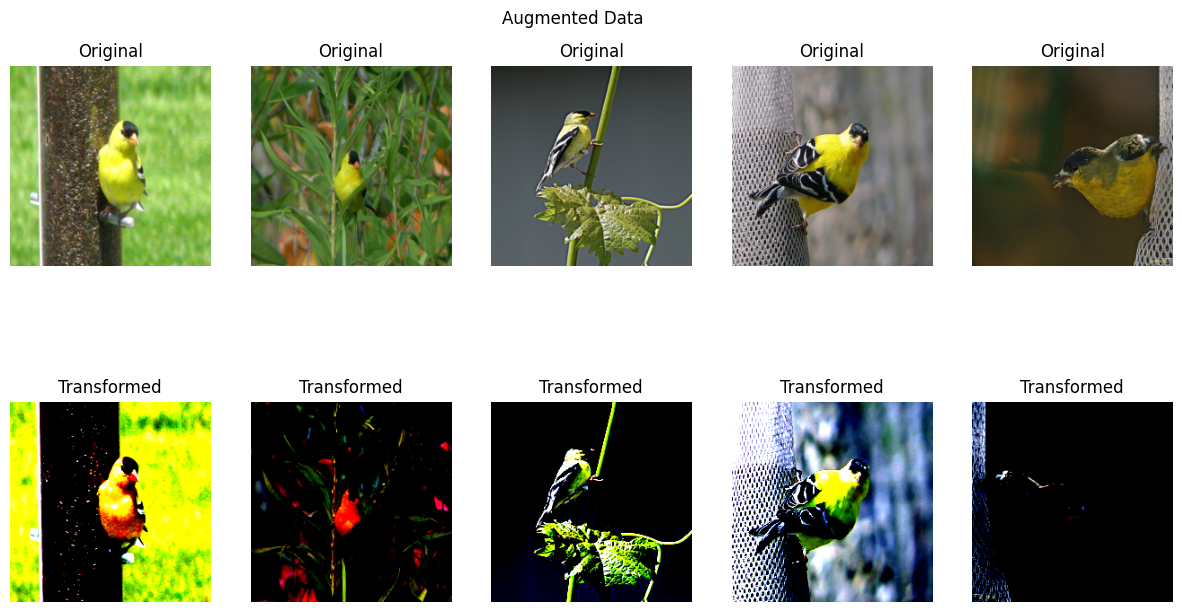

In [58]:

# Define transformations
without_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create class mappings
mapping_path = '/kaggle/input/imagenet-object-localization-challenge/LOC_synset_mapping.txt'

class_mapping_dict = {}
class_mapping_dict_number = {}
mapping_class_to_number = {}
mapping_number_to_class = {}
i = 0
for line in open(mapping_path):
    class_mapping_dict[line[:9].strip()] = line[9:].strip()
    class_mapping_dict_number[i] = line[9:].strip()
    mapping_class_to_number[line[:9].strip()] = i
    mapping_number_to_class[i] = line[:9].strip()
    i += 1

train_path = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train'

# Load and preprocess dataset
dataset_array = []
true_classes = []
images_array = []
images_array_one = []

# Sample only 5 images due to memory constraints
sample_size = 5

for train_class in tqdm(os.listdir(train_path)):
    i = 0
    for el in os.listdir(os.path.join(train_path, train_class)):
        if i < sample_size:
            path = os.path.join(train_path, train_class, el)
            image = Image.open(path).convert('RGB')
            image_resized = without_transform(image)
            image_transformed = transform(image)
            images_array.append(image_resized)
            images_array_one.append(image_transformed)
            true_class = class_mapping_dict[train_class]
            true_classes.append(true_class)
            i += 1
        else:
            break

images_array = torch.stack(images_array)
images_array_one = torch.stack(images_array_one)
true_classes = np.array(true_classes)

# Visualize images after preprocessing
plt.figure(figsize=(15, 8))
plt.suptitle('Augmented Data', x=0.5, y=0.9)

for i, idx in enumerate(range(sample_size)):
    ax1 = plt.subplot(2, sample_size, i + 1)
    ax1.imshow(images_array[i].permute(1, 2, 0).numpy())
    ax1.axis('off')
    ax1.set_title('Original')

    ax2 = plt.subplot(2, sample_size, i + sample_size + 1)
    ax2.imshow(images_array_one[i].permute(1, 2, 0).numpy())
    ax2.axis('off')
    ax2.set_title('Transformed')


plt.show()

In [78]:
class ImageNetDataset(Dataset):
    def __init__(self, class_mapping_dict, root_dir, transform=None, df=None, limit=1000):
        self.root_dir = root_dir
        self.transform = transform
        self.class_mapping_dict = class_mapping_dict
        self.df = df
        
        #  To run just part of dataset
        self.limit = limit
        
        self.images = []
        self.labels = []
        
        self.images_val = []
        self.labels_val = []
        
        if self.df is not None: 
            for img_name in tqdm(os.listdir(root_dir)):
                self.images_val.append(os.path.join(root_dir, img_name))
                #chercher le nom de dossier
                label_name = search_cls(df, img_name)
                #chercher la classe correspondante
                mapping_class_to_number = class_mapping_dict[label_name][1]
                self.labels_val.append(mapping_class_to_number)
        else:
            for train_class in tqdm(os.listdir(root_dir)[:self.limit]):
                class_path = os.path.join(root_dir, train_class)
                for img_name in os.listdir(class_path):
                    self.images.append(os.path.join(class_path, img_name))
                    mapping_class_to_number = class_mapping_dict[train_class][1]
                    self.labels.append(mapping_class_to_number)
            
    
    def __len__(self):
        if self.df is not None:
            return len(self.images_val)
        return len(self.images)
    
    def __getitem__(self, idx):
        
        if self.df is None: 
            img_path = self.images[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
        else:
            img_path = self.images_val[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels_val[idx]
                        
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [79]:
# Load the class mappings
mapping_path = '/kaggle/input/imagenet-object-localization-challenge/LOC_synset_mapping.txt'
   
# Create dataset instances
train_dataset = ImageNetDataset( class_mapping_dict, IMAGE_PATH_TRAIN, transform, )
val_dataset = ImageNetDataset( class_mapping_dict, IMAGE_PATH_VALID, transform, data_frame)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


100%|██████████| 50000/50000 [07:25<00:00, 112.17it/s]


In [80]:
for batch_idx, (images, labels) in enumerate(train_loader):
    print(images.shape)
    break

torch.Size([32, 3, 224, 224])


# ALEXNET MODEL

In [81]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU())
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU())
        
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        
        self.fc3= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 1 if isinstance(m, nn.Conv2d) and m in [self.features[1], self.features[4], self.features[7]] else 0)

        


In [82]:
# Define loss and optimizer
model = AlexNet(num_classes=len(class_mapping_dict)).to(device)
criterion = nn.CrossEntropyLoss()

# Using the saved model to continue training

# Train Process

In [83]:
def top_k_error_rate(output, target, k=5):
    """Compute the top-1 and top-5 error rates, given the output and target."""
    with torch.no_grad():
        max_k = max((1, k))
        batch_size = target.size(0)

        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in range(1, max_k + 1):
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            accuracy_k = correct_k.mul_(100.0 / batch_size)
            error_rate_k = 100.0 - accuracy_k.item()
            res.append(error_rate_k)
        return res

In [84]:
def validate(model, criterion, val_loader):
    """Evaluate the model on the validation set."""
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    
    total_images = 0
    
    cumulative_top1_error_rate = 0.0
    cumulative_top5_error_rate = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            total_images += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Compute top-1 and top-5 error rates
            error_rates = top_k_error_rate(outputs, labels, k=5)

            # Get the top-1 and top-5 error rates
            top1_error_rate = error_rates[0]  # First element is the top-1 error rate
            top5_error_rate = error_rates[-1] # Last element is the top-5 error rate (k=5)

#             top1_error_rate, top5_error_rate = top_k_error_rate(outputs, labels, k=5)[:2]
#             cumulative_top1_error_rate += top1_error_rate
#             cumulative_top5_error_rate += top5_error_rate
            cumulative_top1_error_rate += top1_error_rate
            cumulative_top5_error_rate += top5_error_rate
    
    avg_val_loss = val_loss / len(val_loader)
    avg_top1_error_rate = cumulative_top1_error_rate / len(val_loader)
    avg_top5_error_rate = cumulative_top5_error_rate / len(val_loader)
    
    accuracy = correct / total_images * 100
    
    print(f"Validation Loss: {avg_val_loss:.4f}, Top-1 Error Rate: {avg_top1_error_rate:.2f}%, Top-5 Error Rate: {avg_top5_error_rate:.2f}%")
    
    return avg_val_loss, accuracy, avg_top1_error_rate, avg_top5_error_rate

# Recover weights of saved model

In [85]:
# Recover the model parameters saved in the files during training. Deuxieme
def load_model_with_weights(weight_path, num_classes=1000):
    model = AlexNet(num_classes=num_classes)
    #Load optimizer state 
    checkpoint = torch.load(weight_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    
    
    return model

model = load_model_with_weights(MODEL_INPUT)

In [101]:
def train_next(model, criterion, train_loader, num_epochs, val_loader, weights_file_name=None, initial_lr=0.01, adjust_lr_factor=10):
    """Training loop for a model with manual learning rate adjustment."""
    
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=0.0005)
    best_val_loss = float('inf')
    lr = initial_lr
    total_step = len(train_loader)
    
    # Load optimizer state if a weights file is provided
    if weights_file_name is not None:
        checkpoint = torch.load(os.path.join(SAVE_PATH, weights_file_name), map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        last_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        for param_group in optimizer.param_groups:
                lr = param_group['lr']
    else:
        last_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            if batch_idx % 10000 == 0:
                print(batch_idx, end='\t')
        
        avg_train_loss = running_loss / total_step
        train_acc = correct_train / total_train * 100
        
        val_loss, val_acc, top1_err, top5_err = validate(model, criterion, val_loader)
        
        if val_loss < best_val_loss:
             best_val_loss = val_loss
        else:
             lr /= adjust_lr_factor
        for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}, Top-1 Err: {:.4f}, Top-5 Err: {:.4f}'
              .format(last_epoch + epoch + 1, num_epochs, avg_train_loss, train_acc, val_loss, val_acc, top1_err, top5_err))
        
        # Save model after each epoch
        if epoch >= 2:
            save_path = os.path.join(SAVE_PATH, f"alexnet_epoch_{last_epoch + epoch + 1}.pt")
            torch.save({
                        'epoch': last_epoch + epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_val_loss': best_val_loss,
                    }, save_path)


In [ ]:
train_next(model, criterion, train_loader, num_epochs=90, val_loader=val_loader, weights_file_name="/kaggle/input/model-16/alexnet_epoch_16.pt")

# shows the convolutional kernels learned by the network

In [87]:
# Function to visualize filters
def visualize_filters(layer_weights,number_chanels, num_filters=96 ):
    n_filters = min(layer_weights.size(0), num_filters)  # Show up to num_filters filters
    
    num_rows = 6
    num_cols = (n_filters + num_rows - 1) // num_rows  # Compute the number of rows needed
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5))

    for i in range(n_filters):
        row = i // num_cols
        col = i % num_cols
        
        filter = layer_weights[i].detach().cpu().numpy()
        filter = (filter - filter.min()) / (filter.max() - filter.min())  # Normalize filter to [0, 1]

        if number_chanels == 3:  # If filter has 3 channels (e.g., RGB)
            filter = np.transpose(filter, (1, 2, 0))  # Transpose to (H, W, C)
            axs[row, col].imshow(filter)
        else:  # If filter has a single channel
            axs[row, col].imshow(filter[0], cmap='gray')
        
        axs[row, col].axis('off')

    plt.show()


# Iterate through layers and visualize filters 
def filters_learned(model, number_chanels=1):
    for name, param in model.named_parameters():
        if 'weight' in name and 'layer' in name:
            print(f"Visualizing filters for layer: {name}")
            visualize_filters(param, number_chanels)
            break  # Visualize only the first convolutional layer for brevity

Visualizing filters for layer: layer1.0.weight


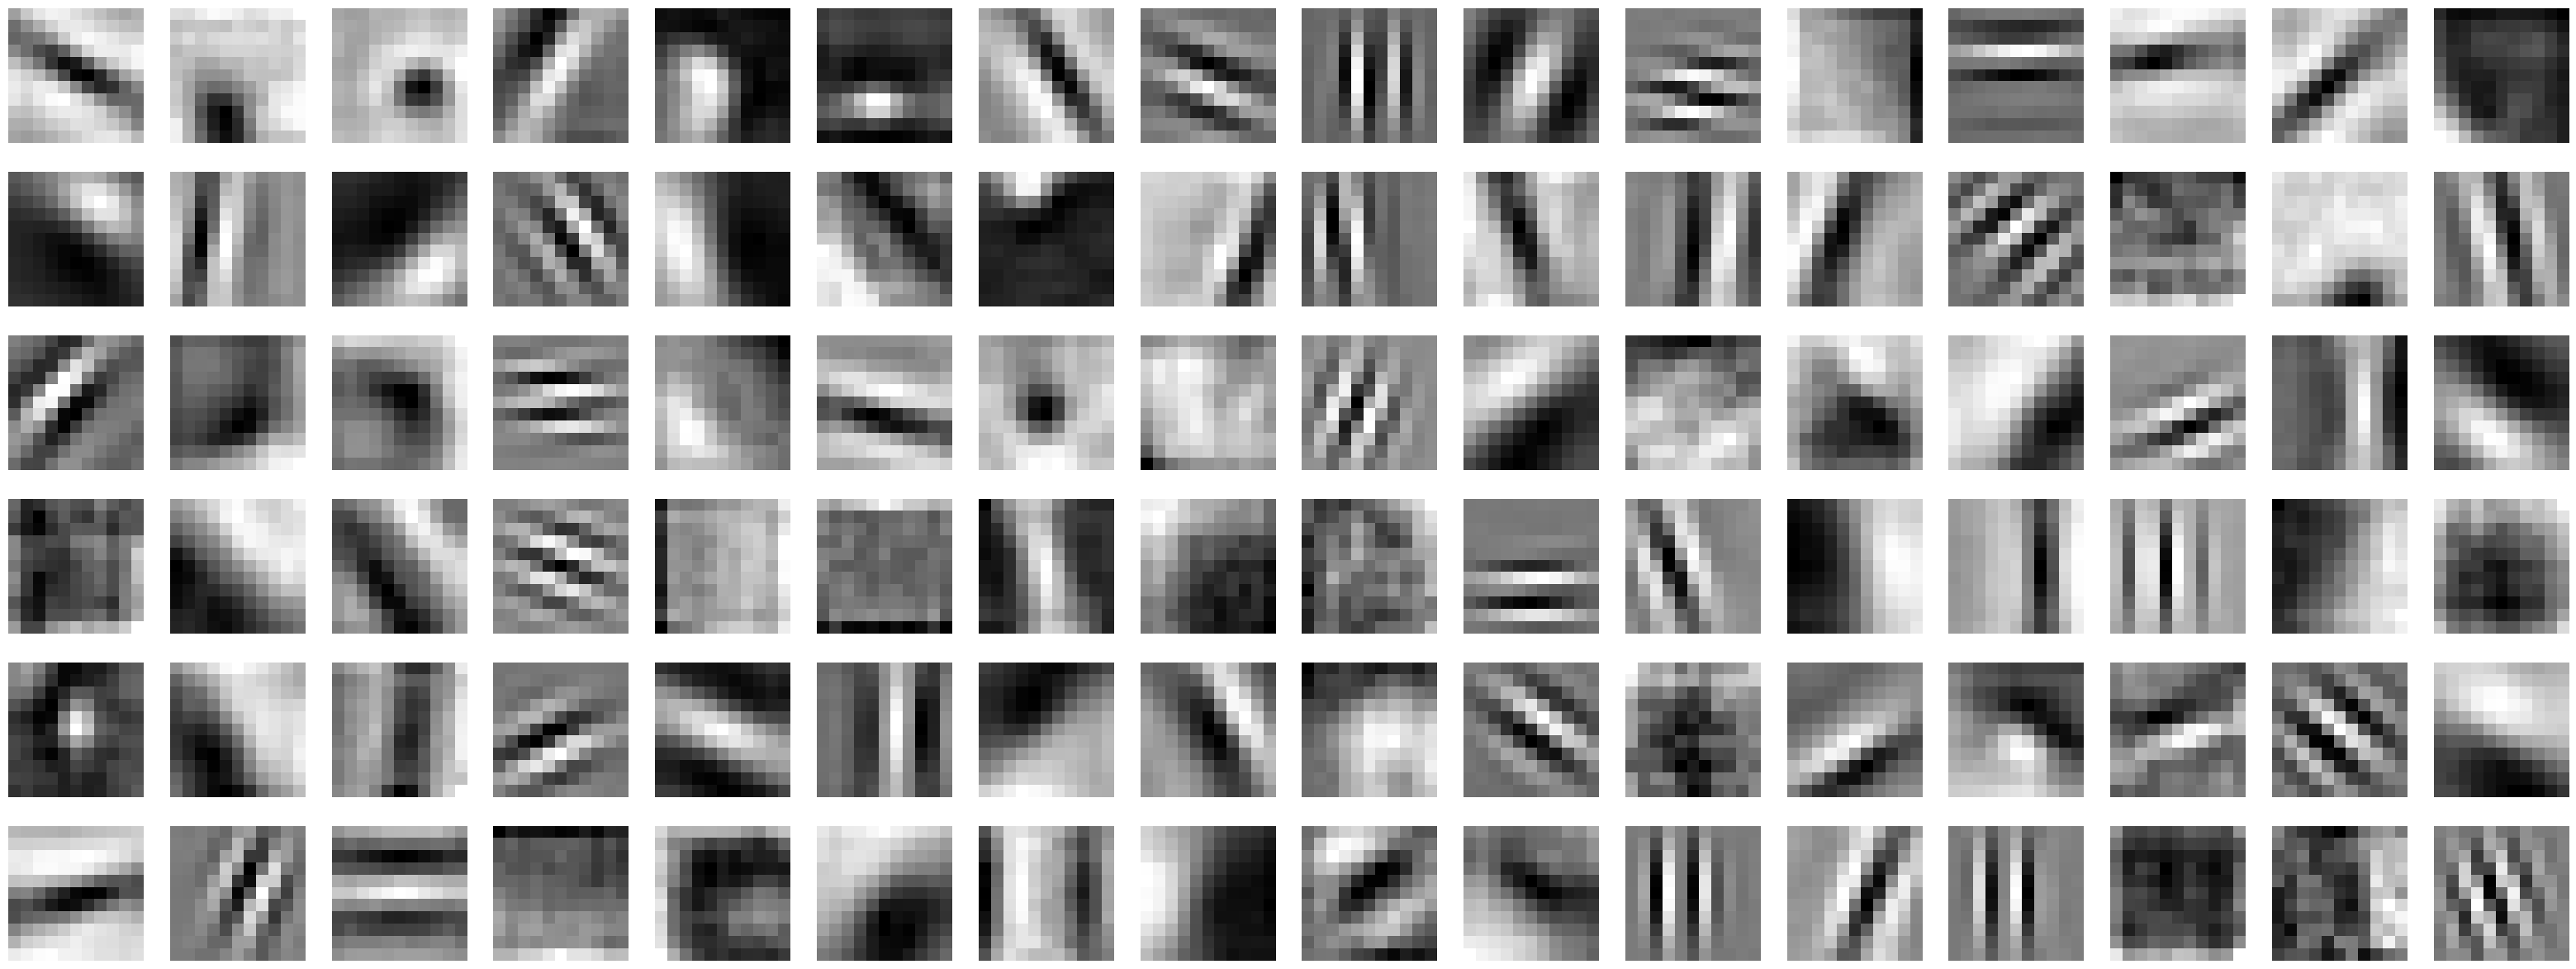

Visualizing filters for layer: layer1.0.weight


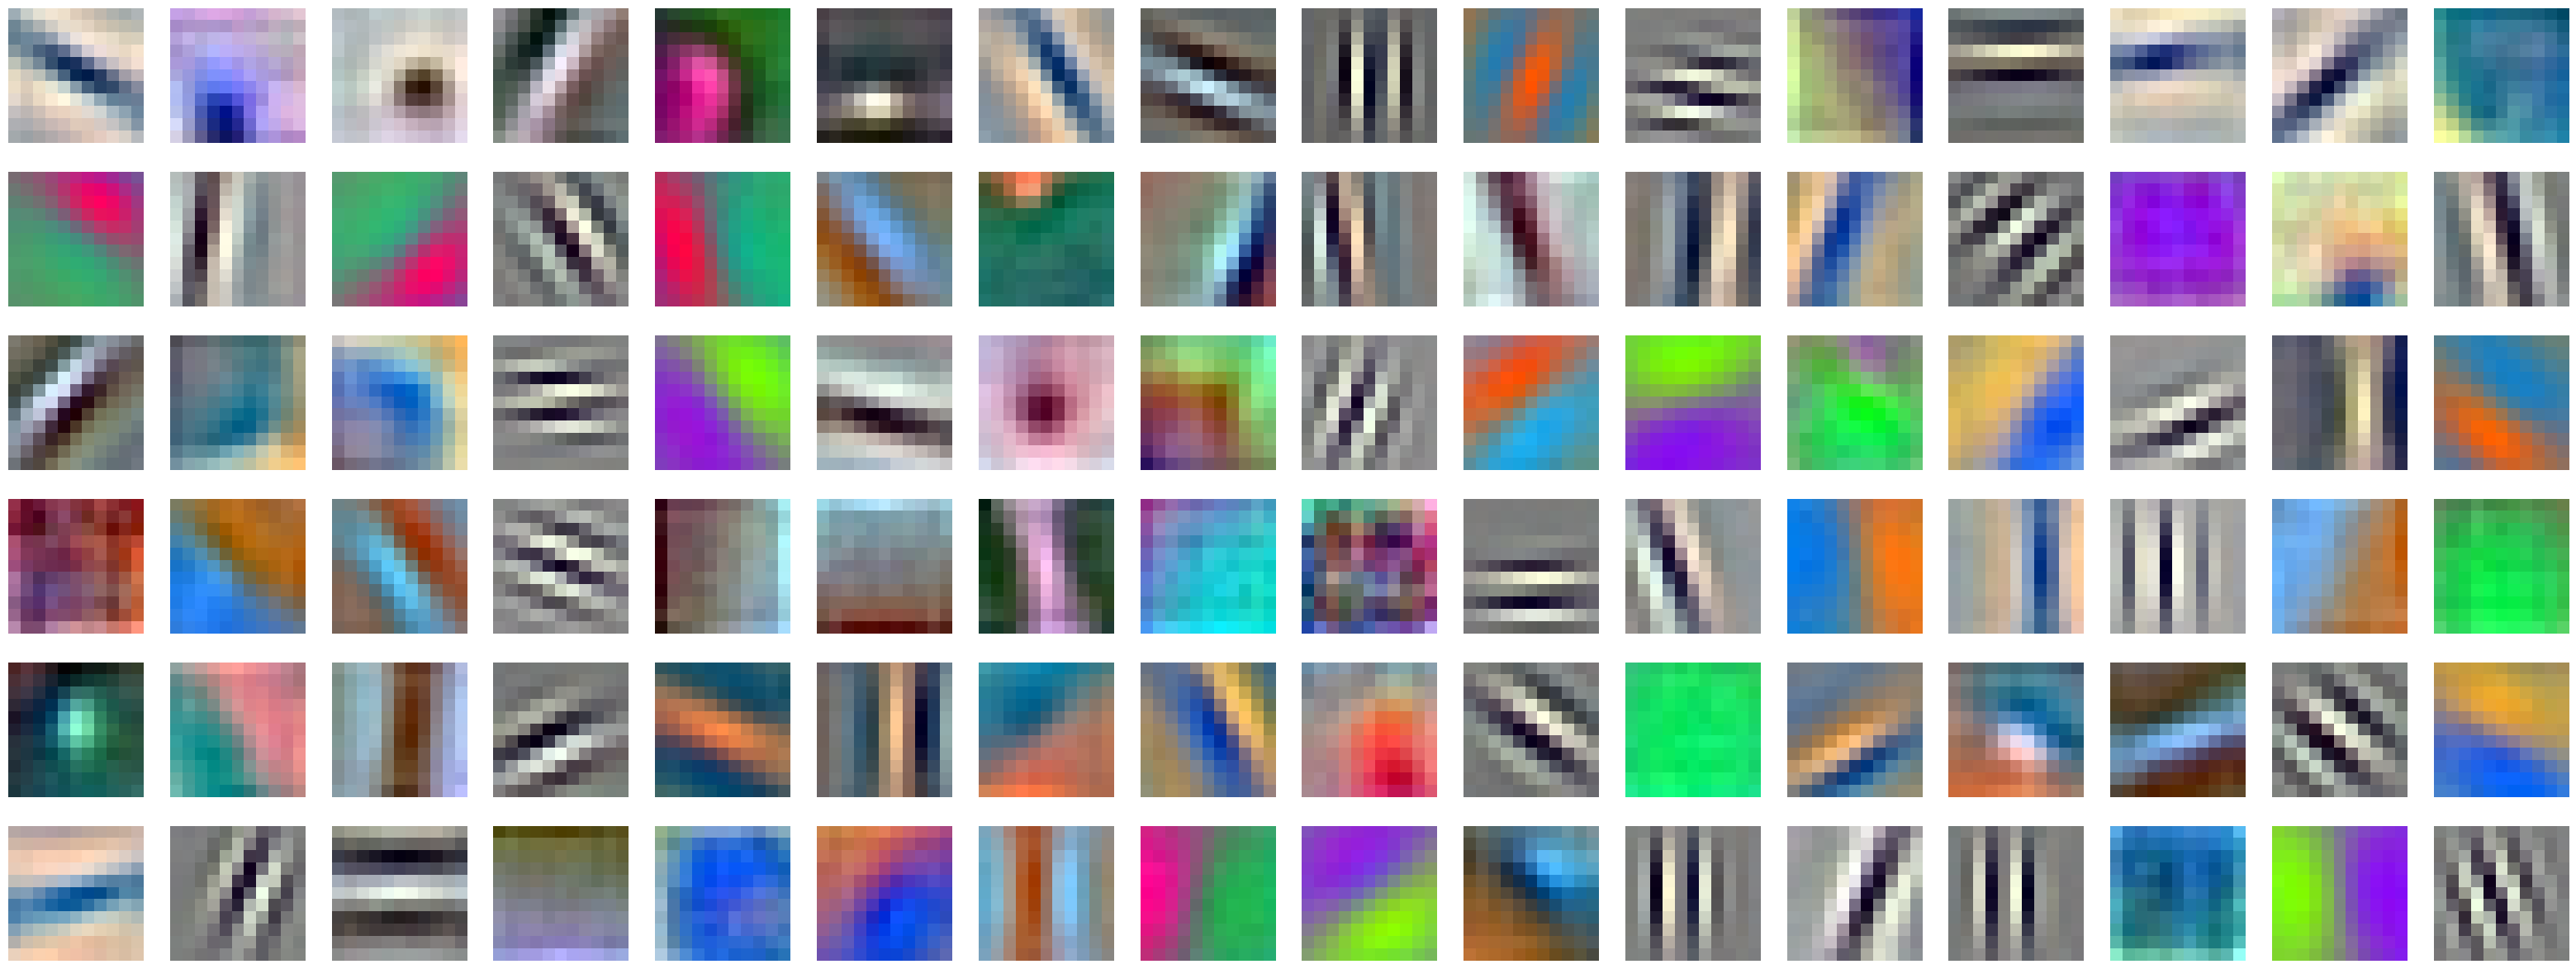

In [37]:
filters_learned(model)
filters_learned(model, number_chanels=3)

# Display test images and the five labels considered most probable by our model

In [88]:
 # Function to get top-5 predictions
def get_top5_predictions(outputs):
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    return top5_prob, top5_catid

# Preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [89]:
# Custom dataset for test images
class ImageNetTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.JPEG')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

In [90]:
# Path to the test images directory
root_dir = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/test"

# Create the dataset and dataloader
dataset = ImageNetTestDataset(root_dir, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

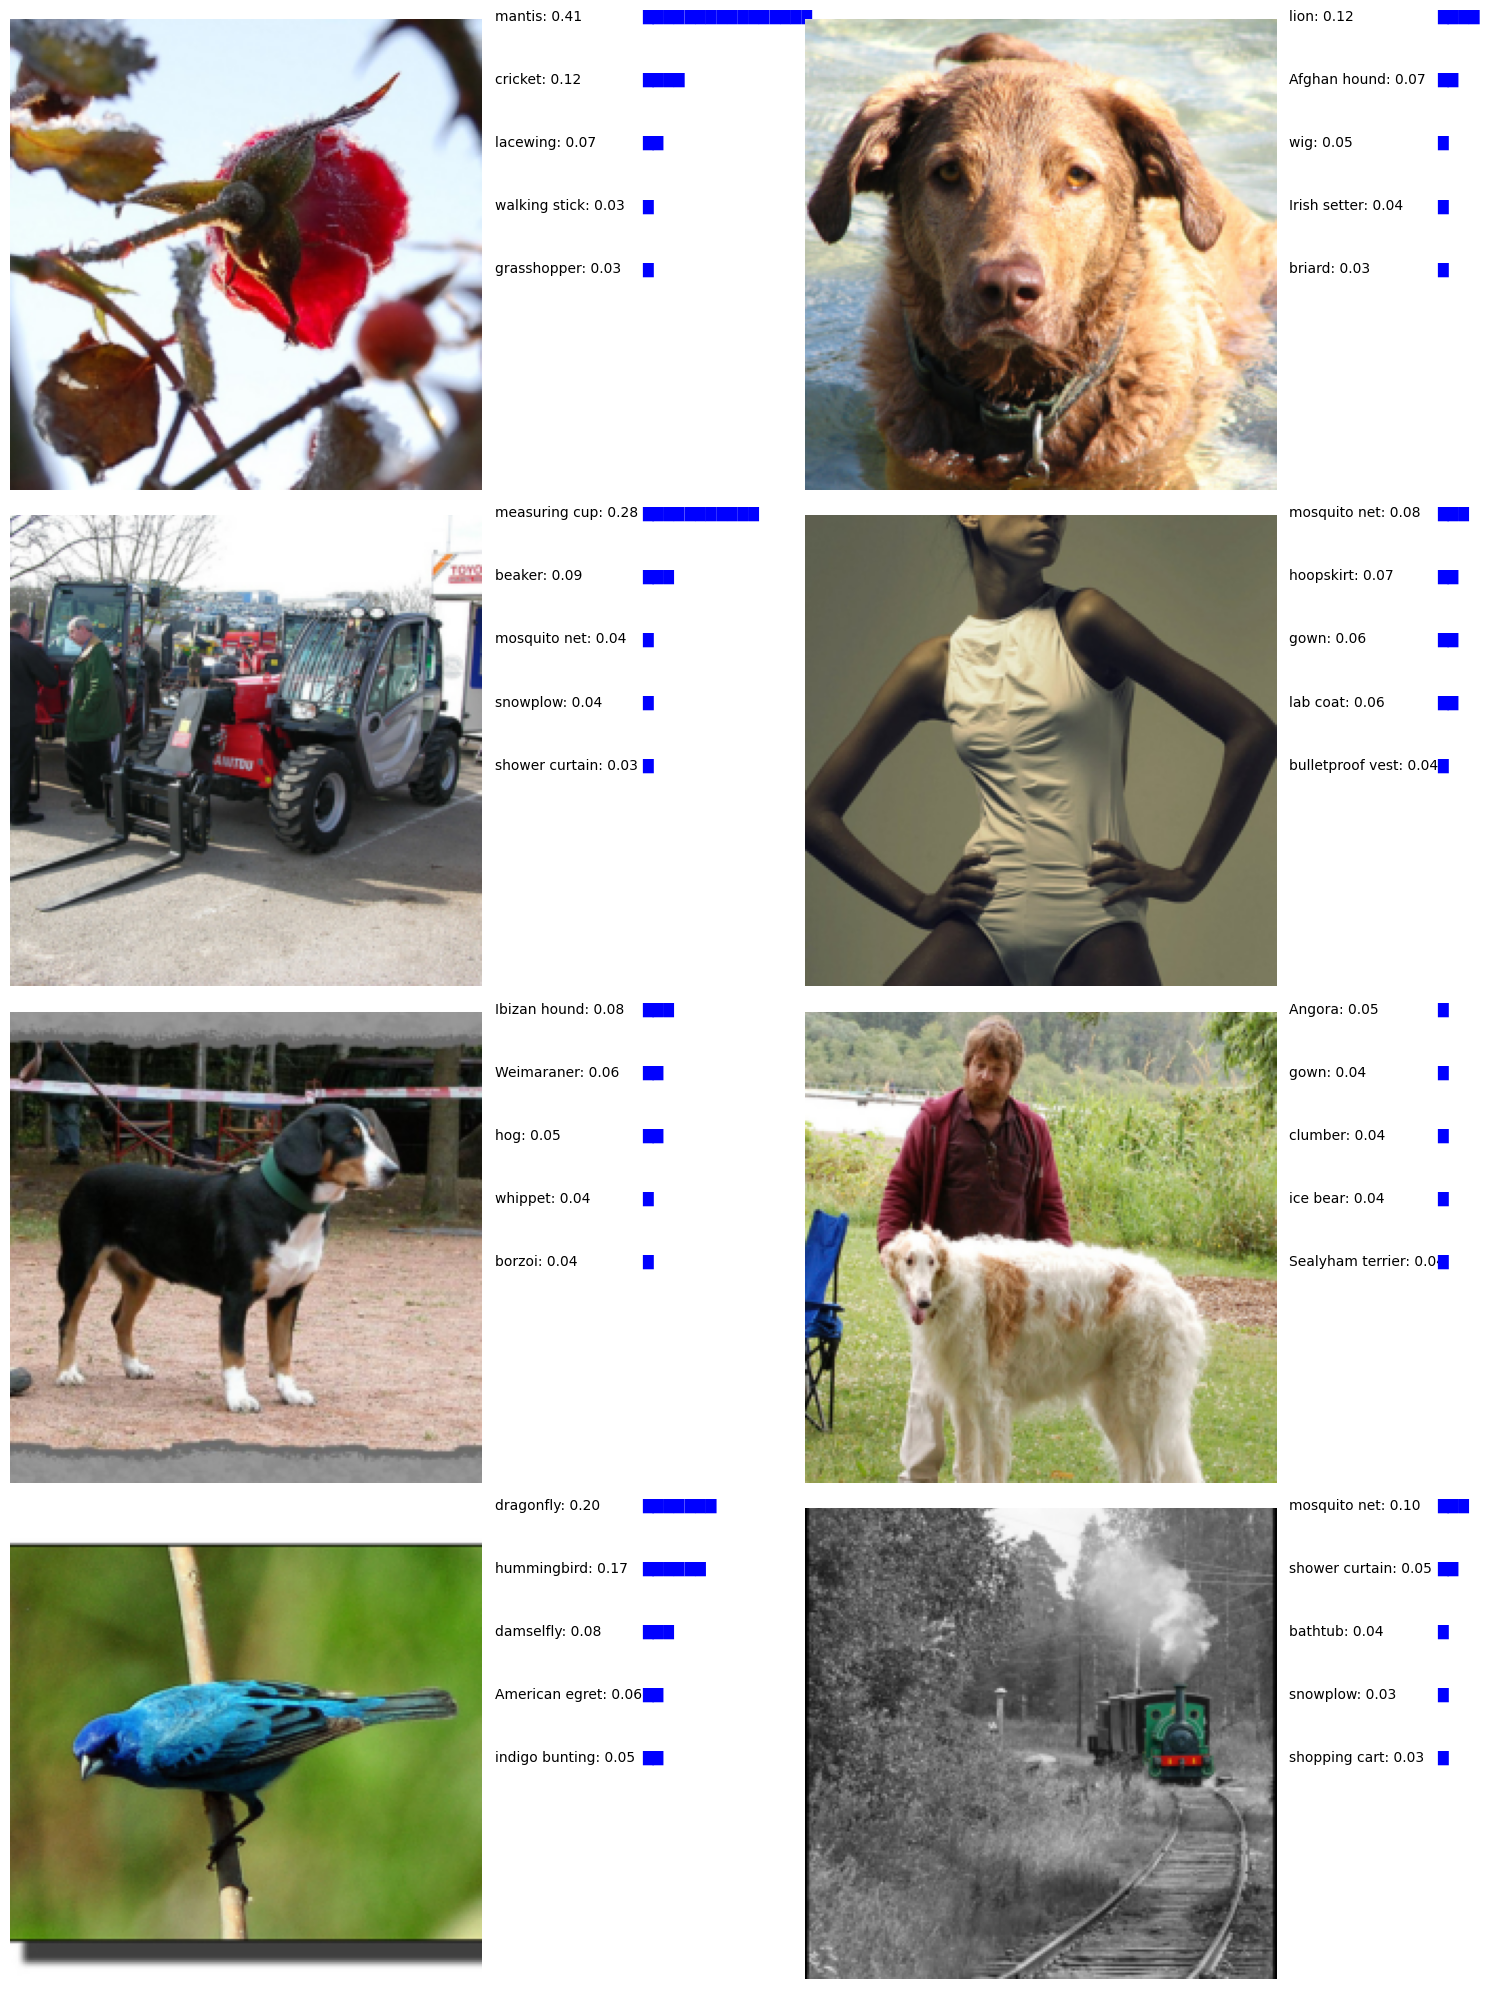

In [100]:
# Ensure the model is in evaluation mode
model.eval()

# Load class labels
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.splitlines()

# Plot images and top-5 predictions
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.9, hspace=0.1)

for idx, (image, img_path) in enumerate(dataloader):
    if idx >= 8:  # Only display 8 images
        break

    # Perform prediction
    with torch.no_grad():
        model.to('cpu')
        outputs = model(image)
    
    top5_prob, top5_catid = get_top5_predictions(outputs)
    
    # Convert image tensor to PIL image for visualization
    img = transforms.ToPILImage()(image.squeeze())
    
    # Display image
    ax = axs.flatten()[idx]
    ax.imshow(img)
    ax.axis('off')
    
    # Display top-5 predictions
    pred_strs = [f"{labels[catid]}: {prob.item():.2f}" for prob, catid in zip(top5_prob[0], top5_catid[0])]
    pred_bars = [f"{'█' * int(prob.item() * 40)}" for prob in top5_prob[0]]

    for i, (pred_str, pred_bar) in enumerate(zip(pred_strs, pred_bars)):
        if i == 0:
            color = 'blue'  # Color correct prediction bar green
        else:
            color = 'blue'   # Color other prediction bars blue
        
        ax.text(230, i*30, pred_str, fontsize=10, color='black')  # Adjusted position for text
        ax.text(300, i*30, pred_bar, fontsize=10, color=color)   # Color for bars

plt.tight_layout()
plt.show()

# Averages the predictions of models

In [92]:
def load_checkpoint(model, optimizer, filepath='checkpoint.pth'):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    return model, optimizer, start_epoch

In [93]:
model1 = AlexNet(num_classes=1000)
model2 = AlexNet(num_classes=1000)

optimizer1 = optim.SGD(model1.parameters(), lr=0.1, momentum=0.9)
optimizer2 = optim.SGD(model2.parameters(), lr=0.1, momentum=0.9)

model1, _, _ = load_checkpoint(model1, optimizer1, filepath='/kaggle/input/best-model-22/alexnet_epoch_22.pt')
model2, _, _ = load_checkpoint(model2, optimizer2, filepath='/kaggle/input/alexnet-weight/alexnet_epoch_15.pt')

# Set the models to evaluation mode
model1.eval()
model2.eval()

# Move models to the device
model1.to(device)
model2.to(device)

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Dr

In [94]:
list_models = [model1, model2]

In [95]:
def get_ensemble_predictions(models, inputs, num_classes):
    preds = torch.zeros((inputs.size(0), num_classes)).to(device)
    for model in models:
        model.eval()
        model.to(device)
        with torch.no_grad():
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds += outputs
    preds /= len(models)
    return preds

def validate(models, criterion, val_loader, num_classes):
    """Evaluate the ensemble of models on the validation set."""
    for model in models:
        model.eval()  # Set all models to evaluation mode

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    total_images = 0
    
    cumulative_top1_error_rate = 0.0
    cumulative_top5_error_rate = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = get_ensemble_predictions(models, images, num_classes)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total_images += labels.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Compute top-1 and top-5 error rates
            errors_rate = top_k_error_rate(outputs, labels, k=5)
            top1_error_rate, top5_error_rate = errors_rate[0], errors_rate[4]
            cumulative_top1_error_rate += top1_error_rate
            cumulative_top5_error_rate += top5_error_rate
    
    avg_val_loss = val_loss / len(val_loader)
    avg_top1_error_rate = cumulative_top1_error_rate / len(val_loader)
    avg_top5_error_rate = cumulative_top5_error_rate / len(val_loader)
    val_acc = correct_val / total_val * 100

    print(f"Validation Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Top-1 Error Rate: {avg_top1_error_rate:.2f}%, Top-5 Error Rate: {avg_top5_error_rate:.2f}%")
    
    return avg_val_loss, val_acc, avg_top1_error_rate, avg_top5_error_rate

In [96]:
criterion = nn.CrossEntropyLoss().to(device)
num_classes = 1000  
list_models = [model1, model2]

# Validate the ensemble of models
validate(list_models, criterion, val_loader, num_classes)

Validation Loss: 2.4508, Val Acc: 45.5820, Top-1 Error Rate: 54.42%, Top-5 Error Rate: 29.33%


(2.450774982352327, 45.582, 54.41658669225848, 29.326615483045426)

Thirty two ILSVRC-2012 test images and the five labels considered most probable by our model. The probability assigned to the correct label is shown with a orange bar (if it happens to be in the top 5).

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Load class labels
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.splitlines()

# Data loader
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

# Plot images and top-5 predictions
fig, axs = plt.subplots(16, 2, figsize=(15, 20))

# Adjust the space between subplots
#plt.subplots_adjust(wspace=0.9, hspace=0.1)

for idx, (image, label) in enumerate(val_loader):
    if idx >= 32:  # Only display 8 images
        break

    # Perform prediction
    with torch.no_grad():
        model.to('cpu')
        outputs = model(image)
    
    top5_prob, top5_catid = get_top5_predictions(outputs)
    
    # Convert image tensor to PIL image for visualization
    img = transforms.ToPILImage()(image.squeeze())
    
    # Display image
    ax = axs.flatten()[idx]
    ax.imshow(img)
    ax.axis('off')
    
    # Display top-5 predictions
    pred_strs = [(f"{labels[catid]}: {prob.item():.2f}", catid ) for prob, catid in zip(top5_prob[0], top5_catid[0])]
    pred_bars = [f"{'█' * int(prob.item() * 40)}" for prob in top5_prob[0]]

    for i, (pred_str, pred_bar) in enumerate(zip(pred_strs, pred_bars)):
        if pred_str[1] == label.item():
            color = 'orange'  # Color correct prediction bar green
        else:
            color = 'blue'   # Color other prediction bars blue
        
        ax.text(230, i*30, pred_str[0], fontsize=10, color='black')  # Adjusted position for text
        ax.text(600, i*30, pred_bar, fontsize=10, color=color)   # Color for bars

plt.tight_layout()
plt.show()